In [1]:
import Veg_meanderpy_ESPIn2023 as mp
import matplotlib.pyplot as plt
import numpy as np
import landlab 
from landlab import RasterModelGrid
#%matplotlib qt

In [2]:
from importlib import reload
reload(mp)

<module 'Veg_meanderpy_ESPIn2023' from '/home/jupyter-corank18@wfu.edu/migrators/Veg_meanderpy_ESPIn2023.py'>

## Input parameters

In [48]:
nit = 2000                   # number of iterations
W = 200.0                    # channel width (m)
D = 6.0                      # channel depth (m)
depths = D * np.ones(nit,)  # channel depths for different iterations  
pad = 100                    # padding (number of nodepoints along centerline)
deltas = 50.0                # sampling distance along centerline 

# Cfs now gets updated in meanderpy.py
Cfs = 0.0 * np.ones((nit,)) # dimensionless Chezy friction factor
#

Cfs_south = 0.05
Cfs_north = 0.1

crdist = 2 * W               # threshold distance at which cutoffs occur
kl = 60.0/(365*24*60*60.0)   # migration rate constant (m/s)
kv =  1.0e-12               # vertical slope-dependent erosion rate constant (m/s)
dt = 2*0.05*365*24*60*60.0     # time step (s)
dens = 1000                  # density of water (kg/m3)
saved_ts = 20                # which time steps will be saved
n_bends = 30                 # approximate number of bends you want to model
Sl = 0.0                     # initial slope (matters more for submarine channels than rivers)
t1 = 500                    # time step when incision starts
t2 = 700                    # time step when lateral migration starts
t3 = 1200                    # time step when aggradation starts
aggr_factor = 2e-9         # aggradation factor (m/s, about 0.18 m/year, it kicks in after t3)

In [49]:
nrow = 1000
ncol = 1001
rvg = RasterModelGrid((nrow,ncol),1)
z = rvg.add_ones("Friction__Factor", at="node", clobber=True)

In [50]:
z[ int(len(z)/2): ] = 0.014
z[ :int(len(z)/2) -1] = 0.011
print(z)
print(len(z))
print( z[ int( len(z)/2 ) ] )


[ 0.011  0.011  0.011 ...,  0.014  0.014  0.014]
1001000
0.014


## Initialize model

In [51]:
ch = mp.generate_initial_channel(W, depths[0], Sl, deltas, pad, n_bends) # initialize channel
chb = mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[]) # create channel belt object

In [52]:
ch.y

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -1.12165688, -5.55413837,  7.1887927 , -6.75521859, -7.67923922,
       -3.45557691, -8.882131  , -2.08634729, -8.50790409, -5.60930936,
        7.64674638, -8.49105068,  1.21265846,  4.38128895, -3.38097745,
       -5.38303182, -7.21236951, -1.97405298, -7.92850488, -7.16523879,
       -0.98110341,  1.01636083, -5.68280043,  2.82989259, -8.86952356,
       -5.24040601, -2.77041597, -4.12965825,  7.27150066, -4.34019623,
        0.68309265,  0.67855184, -7.65432576,  7.77511462,  0.62463125,
       -3.03876098,  1.1389779 ,  0.57398667, -6.41403811,  9.84915715,
       -5.95451223, -4.31278305,  4.56639927, -7.72543722, -7.19348831,
        5.65540974,  9.86435647, -9.81877157,  3.73822842,  4.92808231,
        5.89661759,  1.61434645,  4.12930007, -4.88099117, -2.10831906,
       -5.38604251,  8.41572358,  9.73458282, -0.62358375, -7.47

## Run simulation

100%|██████████| 2000/2000 [01:17<00:00, 25.81it/s]


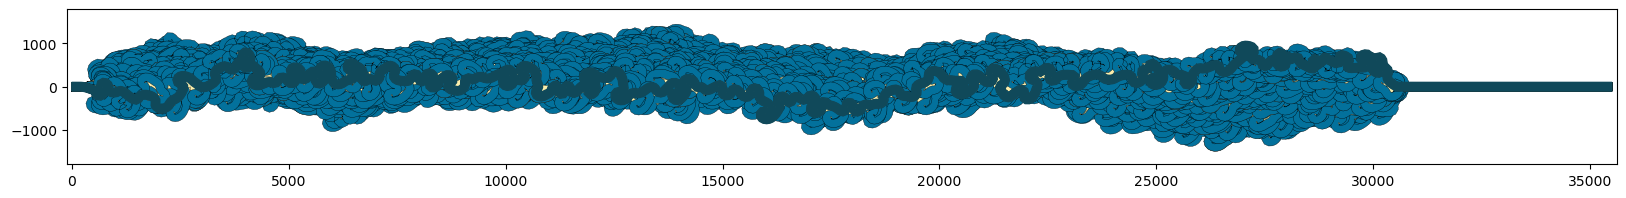

In [53]:
chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor,Cfs_south,Cfs_north) # channel migration
# make migrate function 
fig = chb.plot('strat', 20, 60, chb.cl_times[-1], len(chb.channels)) # plotting

## Sinuosity - Nick 5/14

In [63]:
s = mp.compute_derivatives(ch.x,ch.y,ch.z)
sinuosity = s[-1]/(ch.x[-1]-ch.x[0])
ch.x[-1]

35500.0

In [ ]:
# check the z-profiles (to see whether there is the right amount of incision/aggradation):
plt.figure()
for channel in chb.channels:
    plt.plot(channel.x, channel.z, 'k', linewidth=0.5)

Create a "geomorphologic" display that takes into account that older point bars and cutoffs are covered by vegetation:

In [ ]:
fig = chb.plot('morph', 20, 60, chb.cl_times[-1], len(chb.channels))

Create a map that is colored by the age of the point bars:

In [ ]:
fig = chb.plot('age', 20, 60, chb.cl_times[-1], len(chb.channels))

## Create movie

In [ ]:
dirname = '/home/jupyter-corank18@wfu.edu/migrators/FiguresForMovie/'
chb.create_movie(xmin=10000, xmax=30000, plot_type='strat', filename='movie', dirname=dirname,
                 pb_age = 1, ob_age = 20, end_time = chb.cl_times[-1], n_channels = len(chb.channels))

## Build 3D fluvial model

### Non-interactive definition of x- and y-extent

If the parameters 'xmin', 'xmax', ymin', and 'ymax' are non-zero (as in the cell below), they will be used to define the extent of the area of interest used to build the 3D model. At least initially, it is a good idea to keep this segment relatively small (only a few bends long) to avoid building very large models.

In [ ]:
plt.close('all')

In [ ]:
h_mud = 1.0 * np.ones((len(chb.channels),)) # thickness of overbank deposit for each time step
dx = 10.0 # gridcell size in meters
diff_scale = 2.0 * W/dx
v_coarse = 10.0 # deposition rate of coarse overbank sediment, in m/year (excluding times of no flooding)
v_fine = 0.0 # deposition rate of fine overbank sediment, in m/year (excluding times of no flooding)

chb_3d, xmin, xmax, ymin, ymax, dists, zmaps = mp.build_3d_model(chb, 'fluvial', 
            h_mud=h_mud, h=12.0, w=W, 
            bth=0.0, dcr=10.0, dx=dx, delta_s=deltas, dt=dt, starttime=chb.cl_times[0], endtime=chb.cl_times[-1],
            diff_scale=diff_scale, v_fine=v_fine, v_coarse=v_coarse, 
            xmin=9000, xmax=15000, ymin=-3500, ymax=3500)

In [ ]:
# create plots
fig1,fig2,fig3 = chb_3d.plot_xsection(200, [[0.9,0.9,0],[0.5,0.25,0]], 4)

## Build fluvial model with variable depths and well-defined scrolls

In [ ]:
nit = 2000                   # number of iterations
W = 200.0                    # channel width (m)
D = 6.0
saved_ts = 20                # which time steps will be saved# channel depth (m)
# create variable depth sequence:
depths = D * np.ones((nit,)) + np.repeat(1.5*(np.random.random_sample(int(nit/saved_ts))-0.5), saved_ts)
pad = 100                    # padding (number of nodepoints along centerline)
deltas = 50.0                # sampling distance along centerline           
Cfs = 0.011 * np.ones((nit,)) # dimensionless Chezy friction factor
crdist = 2 * W               # threshold distance at which cutoffs occur
kl = 60.0/(365*24*60*60.0)   # migration rate constant (m/s)
kv =  1.0e-12               # vertical slope-dependent erosion rate constant (m/s)
dt = 2*0.05*365*24*60*60.0     # time step (s)
dens = 1000                  # density of water (kg/m3)
n_bends = 30                 # approximate number of bends you want to model
Sl = 0.0                     # initial slope (matters more for submarine channels than rivers)
t1 = 500                    # time step when incision starts
t2 = 900                    # time step when lateral migration starts
t3 = 10000                    # time step when aggradation starts
aggr_factor = 2e-9         # aggradation factor (m/s, about 0.18 m/year, it kicks in after t3)

ch = mp.generate_initial_channel(W, depths[0], Sl, deltas, pad, n_bends) # initialize channel
chb = mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[]) # create channel belt object

chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor) # channel migration
fig = chb.plot('strat', 20, 60, chb.cl_times[-1], len(chb.channels)) # plotting

In [ ]:
# add a bit more incision:
for i in range(len(chb.channels)):
    chb.channels[i].z = np.ones(np.shape(chb.channels[i].x))*(-0.1 * i)
# create 'h_mud' sequence that mimicks the varibaility in depth through time:
depths1 = depths[::saved_ts]
depths1 = np.hstack((depths1[0], depths1))
h_mud = depths1 - 5.0 # maximum thickness of overbank deposit for each time step
dx = 10.0 # gridcell size in meters
# reduce diffusion length scale:
diff_scale = 1.0 * W/dx
# increase deposition rate of coares sediment:
v_coarse = 20.0 # deposition rate of coarse overbank sediment, in m/year (excluding times of no flooding)
v_fine = 0.0 # deposition rate of fine overbank sediment, in m/year (excluding times of no flooding)

chb_3d, xmin, xmax, ymin, ymax, dists, zmaps = mp.build_3d_model(chb, 'fluvial', 
            h_mud=h_mud, h=12.0, w=W, 
            bth=0.0, dcr=10.0, dx=dx, delta_s=deltas, dt=dt, starttime=chb.cl_times[0], endtime=chb.cl_times[-1],
            diff_scale=diff_scale, v_fine=v_fine, v_coarse=v_coarse, 
            xmin=8000, xmax=15000, ymin=-3500, ymax=3500)

# create plots
fig1,fig2,fig3 = chb_3d.plot_xsection(200, [[0.9,0.9,0],[0.5,0.25,0]], 4)

## Interactive definition of x- and y-extent
After you run the next cell, you need to select the upper left and lower right corners of the area of interest for which you want to build a 3D model. At least initially, it is a good idea to keep this segment relatively small (only a few bends long) to avoid building very large models. The area will only be highlighted (as a red rectangle) after the 3d model building has finished.

In [ ]:
chb_3d, xmin, xmax, ymin, ymax, dists, zmaps = mp.build_3d_model(chb, 'fluvial', 
            h_mud=h_mud, h=12.0, w=W, 
            bth=0.0, dcr=10.0, dx=dx, delta_s=deltas, dt=dt, starttime=chb.cl_times[0], endtime=chb.cl_times[-1],
            diff_scale=diff_scale, v_fine=v_fine, v_coarse=v_coarse, 
            xmin=0, xmax=0, ymin=0, ymax=0)

In [ ]:
# create plots
fig1,fig2,fig3 = chb_3d.plot_xsection(200, [[0.9,0.9,0],[0.5,0.25,0]], 4)

## Build 3D submarine channel model

In [ ]:
nit = 2000                   # number of iterations
W = 200.0                    # channel width (m)
D = 6.0                      # channel depth (m)
depths = D * np.ones((nit,))  # channel depths for different iterations  
pad = 50                    # padding (number of nodepoints along centerline)
deltas = W/4                # sampling distance along centerline           
Cfs = 0.011 * np.ones((nit,)) # dimensionless Chezy friction factor
crdist = 1.5 * W               # threshold distance at which cutoffs occur
kl = 60.0/(365*24*60*60.0)   # migration rate constant (m/s)
kv =  1.0e-12               # vertical slope-dependent erosion rate constant (m/s)
dt = 2*0.05*365*24*60*60.0     # time step (s)
dens = 1000                  # density of water (kg/m3)
saved_ts = 20                # which time steps will be saved
n_bends = 30                 # approximate number of bends you want to model
Sl = 0.0                     # initial slope (matters more for submarine channels than rivers)
t1 = 500                    # time step when incision starts
t2 = 700                    # time step when lateral migration starts
t3 = 1300                    # time step when aggradation starts
aggr_factor = 2e-8         # aggradation factor 

In [ ]:
ch = mp.generate_initial_channel(W, depths[0], Sl, deltas, pad, n_bends) # initialize channel
chb = mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[]) # create channel belt object

In [ ]:
chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor) # channel migration
fig = chb.plot('strat',20,60,chb.cl_times[-1],len(chb.channels)) # plotting

In [ ]:
# check the z-profiles (to see whether there is the right amount of incision/aggradation):
plt.figure()
for channel in chb.channels:
    plt.plot(channel.x, channel.z, 'k', linewidth=0.5)

### Interactive definition of x- and y-extent
After you run the next cell, you need to select the upper left and lower right corners of the area of interest for which you want to build a 3D model. At least initially, it is a good idea to keep this segment relatively small (only a few bends long) to avoid building very large models. The area will only be highlighted (as a red rectangle) after the 3d model building has finished.

In [ ]:
h_mud = 4.0 * np.ones((len(chb.cl_times),)) # thickness of overbank deposit for each time step
dx = 10.0 # gridcell size in meters
diff_scale = 3 * W/dx
v_coarse = 4.0 # deposition rate of coarse overbank sediment, in m/year (excluding times of no flow in channel)
v_fine = 0.0 # deposition rate of fine overbank sediment, in m/year (excluding times of no flow in channel)

chb_3d, xmin, xmax, ymin, ymax, dists, zmaps = mp.build_3d_model(chb, 
            'submarine', h_mud=h_mud, h=15.0, w=W, 
            bth=4.0, dcr=6.0, dx=dx, delta_s=deltas, dt=dt, starttime=chb.cl_times[0], endtime=chb.cl_times[-1],
            diff_scale=diff_scale, v_fine=v_fine, v_coarse=v_coarse, 
            xmin=0, xmax=0, ymin=0, ymax=0)
#             xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)


In [ ]:
fig1,fig2,fig3 = chb_3d.plot_xsection(200, [[0.9,0.9,0], [0.5,0.25,0]], 10)

## Build submarine channel model with along-channel slope

In [ ]:
nit = 2000                   # number of iterations
W = 200.0                    # channel width (m)
D = 6.0                      # channel depth (m)
depths = D * np.ones((nit,))  # channel depths for different iterations  
pad = 50                    # padding (number of nodepoints along centerline)
deltas = W/4                # sampling distance along centerline           
Cfs = 0.011 * np.ones((nit,)) # dimensionless Chezy friction factor
crdist = 1.5 * W               # threshold distance at which cutoffs occur
kl = 60.0/(365*24*60*60.0)   # migration rate constant (m/s)
kv =  1.0e-12               # vertical slope-dependent erosion rate constant (m/s)
dt = 2*0.05*365*24*60*60.0     # time step (s)
dens = 1000                  # density of water (kg/m3)
saved_ts = 20                # which time steps will be saved
n_bends = 30                 # approximate number of bends you want to model
Sl = 0.01                     # initial slope (matters more for submarine channels than rivers)
t1 = 500                    # time step when incision starts
t2 = 700                    # time step when lateral migration starts
t3 = 1300                    # time step when aggradation starts
aggr_factor = 4        # aggradation factor 

ch = mp.generate_initial_channel(W, depths[0], Sl, deltas, pad, n_bends) # initialize channel
chb = mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[]) # create channel belt object

chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor) # channel migration
fig = chb.plot('strat',20,60,chb.cl_times[-1],len(chb.channels)) # plotting

In [ ]:
# check the z-profiles (to see whether there is the right amount of incision/aggradation):
plt.figure()
for channel in chb.channels:
    plt.plot(channel.x, channel.z, 'k', linewidth=0.5)

In [ ]:
h_mud = 4.0 * np.ones((len(chb.cl_times),)) # thickness of overbank deposit for each time step
dx = 10.0 # gridcell size in meters
diff_scale = 3 * W/dx
v_coarse = 4.0 # deposition rate of coarse overbank sediment, in m/year (excluding times of no flow in channel)
v_fine = 0.0 # deposition rate of fine overbank sediment, in m/year (excluding times of no flow in channel)

chb_3d, xmin, xmax, ymin, ymax, dists, zmaps = mp.build_3d_model(chb, 
            'submarine', h_mud=h_mud, h=15.0, w=W, 
            bth=4.0, dcr=6.0, dx=dx, delta_s=deltas, dt=dt, starttime=chb.cl_times[0], endtime=chb.cl_times[-1],
            diff_scale=diff_scale, v_fine=v_fine, v_coarse=v_coarse, 
            xmin=0, xmax=0, ymin=0, ymax=0)

In [ ]:
fig1,fig2,fig3 = chb_3d.plot_xsection(200, [[0.9,0.9,0], [0.5,0.25,0]], 10)